In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda, GlobalAveragePooling2D

In [5]:
# Load CIFAR-100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')


In [6]:
# Ensure x_train and x_test are float32 and normalized
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Resize from 32x32 to 128x128
x_train = tf.image.resize(x_train, [128, 128])
x_test = tf.image.resize(x_test, [128, 128])

# One-hot encode labels
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)


2025-06-17 02:18:12.900345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[50000,128,128,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator Simple allocator


ResourceExhaustedError: {{function_node __wrapped__ResizeBilinear_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[50000,128,128,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator Simple allocator [Op:ResizeBilinear] name: 

In [ ]:
# to Define U-Net-like encoder for classification
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x)(inputs)  # Normalization already done

# Contracting path (Encoder)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2, 2))(c4)

# Classification head
x = GlobalAveragePooling2D()(p4)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(100, activation='softmax')(x)

model = Model(inputs=[inputs], outputs=[outputs])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,244 (1.34 MB)

 Trainable params: 352,244 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks and training
checkpointer = ModelCheckpoint('cifar100_unet_classifier.h5', verbose=1, save_best_only=True)
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss'),
    TensorBoard(log_dir='logs')
]

# Definig the early stopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)



results = model.fit(
    x_train, y_train,
    validation_split=0.1,
    batch_size=16,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25


C:\Users\NTECH\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 602s 211ms/step - accuracy: 0.0274 - loss: 4.4188 - val_accuracy: 0.0648 - val_loss: 4.0531
Epoch 2/25
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 559s 199ms/step - accuracy: 0.0815 - loss: 3.8909 - val_accuracy: 0.1382 - val_loss: 3.6027
Epoch 3/25
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 553s 197ms/step - accuracy: 0.1329 - loss: 3.5848 - val_accuracy: 0.1694 - val_loss: 3.3991
Epoch 4/25
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 544s 193ms/step - accuracy: 0.1789 - loss: 3.3417 - val_accuracy: 0.2190 - val_loss: 3.1646
Epoch 5/25
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 547s 194ms/step - accuracy: 0.2088 - loss: 3.1635 - val_accuracy: 0.2302 - val_loss: 3.0599
Epoch 6/25
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 549s 195ms/step - accuracy: 0.2417 - loss: 2.9940 - val_accuracy: 0.2570 - val_loss: 2.9045
Epoch 7/25
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 547s 194ms/step - accuracy: 0.2708 - loss: 2.8532 - val_accuracy: 0.2812 - val_loss: 2.8602
Epoch 8/25
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 542s 193ms/step - accuracy: 0.2

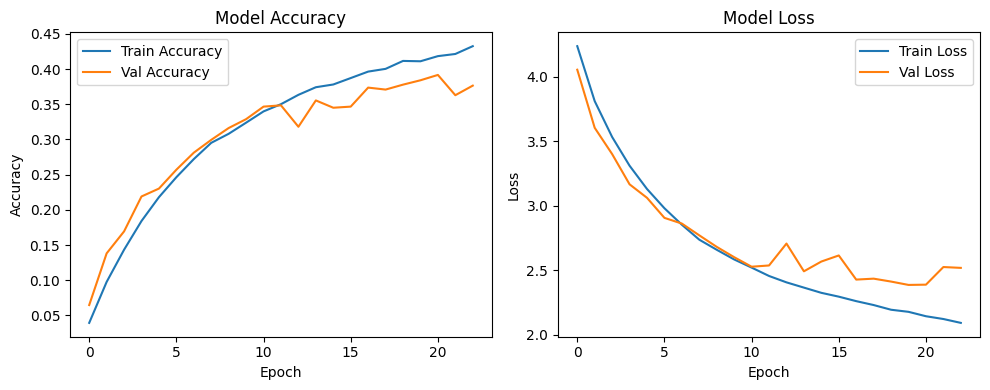

In [ ]:
# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()